In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

import keras.backend as K
from keras.callbacks import Callback
from keras.utils import Progbar

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

from PIL import Image
import cv2 as cv
import os
import shutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


# Final Project - Data Science and Advanced Python Concepts Workshop
Workshop conducted by Ossnat Bar-Shira
## _Replication of the Yolo v1 Algorithm_
_Original article: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf <br>
Authors: Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi <br>
Year: 2016_ <br>

Team for this replication project:
- Ailan Kalledat
- Sophie Lepennetier
- Nele Werner

# 1. Data exploration
## 1.a. Display the first image as an example:

In [3]:
# Taking a shrinked version of the image to avoid unnecessary computation
images = Image.open('/kaggle/input/pascalvoc-yolo/images/000001.jpg').resize((448, 448))

first_image = np.array(images)
first_image.shape

(448, 448, 3)

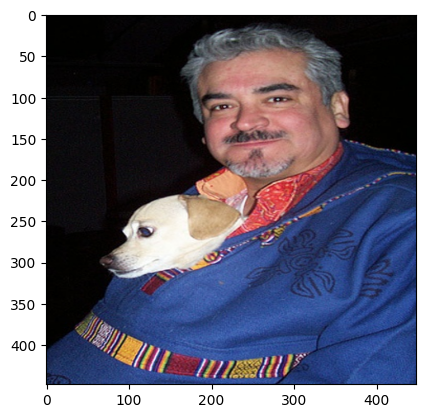

In [4]:
plt.imshow(first_image)

## 1.b. Display a detection square from the raw data
Goal: to better understand the data contained in the Label files.

In [5]:
def draw_rectangle_image_rawdata(x_center, y_center, width, height, image):
    """
    Display an image, the grid cells and only one rectangle from the raw data (not the YOLO format)
    """
    # Create the figure and axes
    fig, ax = plt.subplots()
    
    # Display the image
    ax.imshow(image)
    
    # Calculate grid cell size
    cell_width = image.shape[1] / 7
    cell_height = image.shape[0] / 7

    # Draw vertical grid lines
    for i in range(1, 7):
        x = i * cell_width
        ax.axvline(x, color='blue', linestyle='--', linewidth=0.5)

    # Draw horizontal grid lines
    for j in range(1, 7):
        y = j * cell_height
        ax.axhline(y, color='blue', linestyle='--', linewidth=0.5)
    
    # Add a rectangle to the plot
    rectangle = patches.Rectangle(
        (x_center - width/2, y_center - height/2),
        width,
        height,
        edgecolor='red',
        facecolor='none',  # No filling
        linewidth=2,
    )
    ax.add_patch(rectangle)
    rectangle.set_zorder(3) # Palce the rectangle in front
    
    # Add the cross in the center
    ax.plot(x_center, y_center, 'r+', linewidth=2)
    
    # Display the plot
    plt.show()

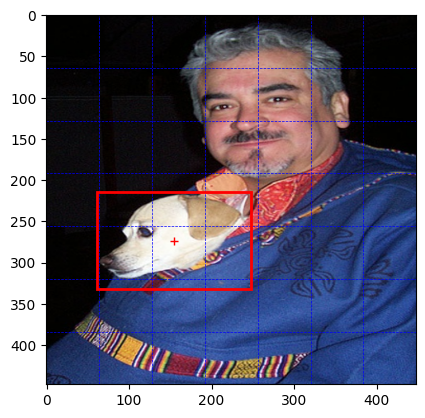

In [6]:
# Example of use on the first image
x_center = 0.34419263456090654 * 448  # The number has been taken from the label file
y_center = 0.611 * 448  # from label file
width = 0.4164305949008499 * 448  # from label file
height = 0.262 * 448  # from label file

draw_rectangle_image_rawdata(x_center, y_center, width, height, first_image)

# 2. Data preprocessing: convert label files to YOLO format, and resize and normalize images

What we know:
- an element in the picture is defined by a class (20 in total)
- the element's position is defined by the position of a box on the picture (i.e. the rectangle previously displayed), according to the image whose area is considered equal to 1.

What we have in the raw data:
- the number of the class
- the position of the box's center according to the image size (whose area = 1) [x_center and y_center]
- the width and height of the box according to the image size (=1)

What YOLO format is (e.i. the objective of this transformation):
- one-hot encoding of the class
- probabilities of this element
- define which grid cell the box belongs to
- the relative position of the box center according to the grid cell (whose area = 1 here)
- the height and width of the box, again still according to the image (area = 1)

## 2.a. Create a function that converts **one** image and its label to YOLO format

In [7]:
def read(image_filename, label_filename):
    """
    Parameters:
        - image_filename: name of the image
        - label_filename: name of the label file

    Returns
        - the image in the format of a normalized pixel array
        - the label in YOLO format
    """
    ## IMAGE
    # Construct the full path
    images_directory = '/kaggle/input/pascalvoc-yolo/images/'
    image_path = os.path.join(images_directory, image_filename)
    # Open and resize the image using OpenCV
    image_matrix = cv.imread(image_path)
    image_matrix = cv.cvtColor(image_matrix, cv.COLOR_BGR2RGB)
    image_matrix = cv.resize(image_matrix, (448, 448))
    image_matrix = image_matrix / 255 # normalization of each pixel according to RGB scale

    ## LABEL
    # Construct the full path
    labels_directory = '/kaggle/input/pascalvoc-yolo/labels/'
    label_path = os.path.join(labels_directory, label_filename)
    # Read the content of the label file, split lines, split values, and convert to int or float
    with open(label_path, 'r') as file:
        label_content = [[float(value) for i, value in enumerate(line.split())] for line in file.read().splitlines()]
  
    # output shape preparation
    label_matrix = np.zeros([7, 7, 30])
    
    for l in label_content:
        # class
        cl = int(l[0]) 
        
        # saves coordinate of the center points of the element
        x_center = l[1] 
        y_center = l[2] 
        width = l[3] 
        heigth = l[4] 
        
        # adapts x and y coordinates to the grid cell in which the object is 
        loc = [7 * x_center, 7 * y_center]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
        # coordinates of the object center relative to the grid cell
        y = loc[1] - loc_i 
        x = loc[0] - loc_j
        
        # check if there is not already another element in the same grid cell (if yes: do nothing)
        if label_matrix[loc_i, loc_j, 24] == 0:
            label_matrix[loc_i, loc_j, cl] = 1 # class
            label_matrix[loc_i, loc_j, 20:24] = [x, y, width, heigth] # coordinates
            label_matrix[loc_i, loc_j, 24] = 1  # confidence presence of element within this bounding box

    return image_matrix, label_matrix

## 2.b. Display detection squares from YOLO format data
Goal: to better understand the output

In [8]:
def draw_rectangle_image_yolo(yolo_matrix, image):
    """
    Display an image, the grid cells, and rectangles from YOLO format matrix.
    """
    # Create the figure and axes
    fig, ax = plt.subplots()
    
    # Display the image
    ax.imshow(image)
    
    # Calculate grid cell size
    cell_width = image.shape[1] / 7
    cell_height = image.shape[0] / 7

    # Draw vertical grid lines
    for i in range(1, 7):
        x = i * cell_width
        ax.axvline(x, color='blue', linestyle='--', linewidth=0.5)

    # Draw horizontal grid lines
    for j in range(1, 7):
        y = j * cell_height
        ax.axhline(y, color='blue', linestyle='--', linewidth=0.5)
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '#FF5733', '#33FF57', '#5733FF', '#33FFFF',
              '#FF33A1', '#A1FF33', '#FF3385', '#FF8533', '#33FFC1', '#C1FF33', '#FF335A', '#335AFF']
    for line in range(7):
        for column in range(7):
            if np.any(yolo_matrix[line, column] != 0):
                # Extract relevant information from YOLO matrix
                x_center_rel, y_center_rel, width_rel, height_rel = yolo_matrix[line, column, 20:24]
                
                # Calculate absolute coordinates and dimensions
                x_center = (column + x_center_rel)/7 *448
                y_center = (line + y_center_rel)/7 * 448
                width = width_rel * 448
                height = height_rel * 448
                
                # Extract the class to define the color
                cls = np.argmax(yolo_matrix[line, column, :20] == 1)
                
                # Add a rectangle to the plot
                rectangle = patches.Rectangle(
                    (x_center - width / 2, y_center - height / 2),
                    width,
                    height,
                    edgecolor=colors[cls],
                    facecolor='none',  # No filling
                    linewidth=2,
                )
                ax.add_patch(rectangle)
                rectangle.set_zorder(3)  # Place the rectangle in front

                # Add the cross in the center
                ax.plot(x_center, y_center, color=colors[cls], marker='+', linewidth=2)

    # Display the plot
    plt.show()

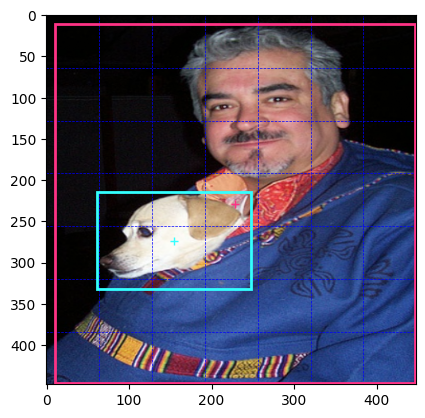

In [9]:
# This is just a test to check the previous code
number = '001' # 3 digits
image_name = '000' + number + '.jpg'
label_name = '000' + number + '.txt'
    
image_matrix, label_matrix = read(image_name, label_name)
draw_rectangle_image_yolo(label_matrix,image_matrix)

label_matrix's shape = (7, 7, 30):
- 7x7 grid cells
- 30 features (20 classes + (4 bounding box features + 1 confidence in the presence of an element within this bounding box] * 2)

We can see in this example of the cell in the second column and fourth row (indexes starting at 0):
- a 1 in the 11th position representing class = dog
- the center of the box is placed at (x=0.409, y=0.277) of **the grid cell scale**
- the shape of the box is (w=0.416, h=0.262) according to **the image scale**
- 1 confidence level for the dog being in this grid cell
- five 0 for another bounding box are prepared for another prediction (during training)

## 2.c. Create a generator to convert **a batch** of images and their labels to YOLO format

In [10]:
class My_Custom_Generator(keras.utils.Sequence) :
    """
    Create a generator to transform a batch of images and their labels into YOLO format, batch after batch
    """
    def __init__(self, images_filenames, labels_filenames, batch_size):
        """
        Initialize the generator with the paths of the images and labes, an the disired size of the batch
        
        Parameters:
            - images_filenames: array of images' names
            - labels_filenames: array of labels' names
            - batch_size: the desired size of the batch
        """
        self.images = images_filenames
        self.labels = labels_filenames
        self.batch_size = batch_size

        
    def __len__(self):
        """
        This method returns the total number of batches of batch_size that the generator can produce
        """
        return (np.ceil(len(self.images) / self.batch_size)).astype(int)
        # np.ceil ensures that even if the total number of examples is not perfectly divisible by the batch size, it returns an integer (rounding up)

        
    def __getitem__(self, idx):
        """
        This method is called to obtain a batch of images and labels in YOLO format at index idx
        Return:
            - np.array of a batch of images normalized and resized
            - np.array of a batch of labels in the YOLO format (7x7x30)
        """ 
        # Lists' division according to the batch size
        batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        set_image = []
        set_label = []

        for i in range(0, len(batch_x)):
            image_filename = batch_x[i]
            label_filename = batch_y[i]
            image_matrix, label_matrix = read(image_filename, label_filename)
            set_image.append(image_matrix)
            set_label.append(label_matrix)
        
        return np.array(set_image), np.array(set_label)

The image is 000021.jpg
The label matrix's shape is now (7, 7, 30)


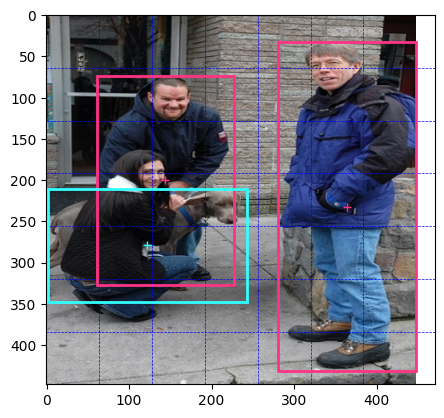

In [11]:
# This is just a test to check the previous code
images_directory = '/kaggle/input/pascalvoc-yolo/images/'
image_files = sorted(os.listdir(images_directory))[:100]
labels_directory = '/kaggle/input/pascalvoc-yolo/labels/'
label_files = sorted(os.listdir(labels_directory))[:100]
batch_size = 10
idx = 2

# Lists' division according to the batch size
batch_x = image_files[idx * batch_size : (idx+1) * batch_size]
batch_y = label_files[idx * batch_size : (idx+1) * batch_size]

set_image = []
set_label = []

for i in range(0, len(batch_x)):
    image_name = batch_x[i]
    label_name = batch_y[i]
    image_matrix, label_matrix = read(image_name, label_name)
    set_image.append(image_matrix)
    set_label.append(label_matrix)

print(f'The image is {image_files[idx*batch_size]}')
print(f'The label matrix\'s shape is now {set_label[0].shape}')
draw_rectangle_image_yolo(set_label[0],set_image[0])

# 3. Building the Model
## 3.a. Last layer resizing the output
After running the data through the YOLO algorithm, the result is not necessarily interpretable. This function will produce the desired shape, which corresponds to the one we defined above: 7x7x30.

In [12]:
class Yolo_Reshape(tf.keras.layers.Layer):
    def __init__(self, target_shape):
        # Ensure that the characteristics of the parent class are taken into account
        super(Yolo_Reshape, self).__init__()
        self.target_shape = tuple(target_shape)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'target_shape': self.target_shape
        })
        return config

    def call(self, input): # forward propagation
        # grids 7x7
        S = [self.target_shape[0], self.target_shape[1]]
        # classes
        C = 20
        # no of prediction per grid
        B = 2

        idx1 = S[0] * S[1] * C # 7x7xclasses
        idx2 = idx1 + S[0] * S[1] * B # previous part + 7x7x2

        # class probabilities
        class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C])) # Select class predictions of each grid cell
        class_probs = K.softmax(class_probs) # Apply softmax on the class probabilities -> sum=1

        #confidence
        confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
        confs = K.sigmoid(confs) # Apply sigmoid to obtain confidence between [0, 1]

        # boxes
        boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes) # Apply sigmoid to obtain bounding box features between [0 ,1]

        outputs = K.concatenate([class_probs, confs, boxes])
        return outputs

The input to the `call` method is the last vector of the CNN. The method then divides this last vector into smaller batches. Finally, the batches are concatenated to form the output tensor <br>
To simplify the visualization of the input and temporary array shapes of the `call` method, let's consider that there is only one image in the batch. <br>
#### Input
**input.shape = (7x7x30=1470)**
$$
\text{input} = \left[ \, \begin{bmatrix}
        \text{30 features of grid cell}_{1} & , & \text{30 features of grid cell}_{2} & , & \ldots & , & \text{30 features of grid cell}_{49} \\
    \end{bmatrix} \, \right]
$$
<br>
#### Temporary arrays
**class_probs.shape = (7, 7, 20)**
$$
\text{class_probs} = \left[ \, \begin{bmatrix}
    \overbrace{\begin{bmatrix}
        \mathbb{P}(C_1) &,& \mathbb{P}(C_2) &,& \ldots &,& \mathbb{P}(C_{20})
    \end{bmatrix}}^{\text{grid cell (1,1)}}
    & \ldots &
    \overbrace{\begin{bmatrix}
        \mathbb{P}(C_1) &,& \mathbb{P}(C_2) &,& \ldots &,& \mathbb{P}(C_{20})
    \end{bmatrix}}^{\text{grid cell (1,7)}}
    \\
    \vdots & \ddots & \vdots
    \\
    \overbrace{\begin{bmatrix}
        \mathbb{P}(C_1) &,& \mathbb{P}(C_2) &,& \ldots &,& \mathbb{P}(C_{20})
    \end{bmatrix}}^{\text{grid cell (7,1)}}
    & \ldots &
    \overbrace{\begin{bmatrix}
        \mathbb{P}(C_1) &,& \mathbb{P}(C_2) &,& \ldots &,& \mathbb{P}(C_{20})
    \end{bmatrix}}^{\text{grid cell (7,7)}}
    \\
\end{bmatrix} \, \right]
$$
<br><br>
**confs.shape = (7, 7, 2)**
$$
\text{confs} = \left[ \, \begin{bmatrix}
    \overbrace{\begin{bmatrix}
        \text{confidence of box 1} &,& \text{confidence of box 2}
    \end{bmatrix}}^{\text{grid cell (1,1)}}
    & \ldots &
    \overbrace{\begin{bmatrix}
        \text{confidence of box 1} &,& \text{confidence of box 2}
    \end{bmatrix}}^{\text{grid cell (1,7)}}
    \\
    \vdots & \ddots & \vdots
    \\
    \overbrace{\begin{bmatrix}
        \text{confidence of box 1} &,& \text{confidence of box 2}
    \end{bmatrix}}^{\text{grid cell (7,1)}}
    & \ldots &
    \overbrace{\begin{bmatrix}
        \text{confidence of box 1} &,& \text{confidence of box 2}
    \end{bmatrix}}^{\text{grid cell (7,7)}}
    \\
\end{bmatrix} \, \right]
$$
<br><br>
**boxes.shape = (7, 7, 2x4=8)**
$$
\text{boxes} = \left[ \, \begin{bmatrix}
    \overbrace{\begin{bmatrix}
        x_1 &,& y_1 &,& w_1 &,& h_1 &,& x_2 &,& y_2 &,& w_2 &,& h_2
    \end{bmatrix}}^{\text{grid cell (1,1)}}
    & \ldots &
    \overbrace{\begin{bmatrix}
        x_1 &,& y_1 &,& w_1 &,& h_1 &,& x_2 &,& y_2 &,& w_2 &,& h_2
    \end{bmatrix}}^{\text{grid cell (1,7)}}
    \\
    \vdots & \ddots & \vdots
    \\
    \overbrace{\begin{bmatrix}
        x_1 &,& y_1 &,& w_1 &,& h_1 &,& x_2 &,& y_2 &,& w_2 &,& h_2
    \end{bmatrix}}^{\text{grid cell (7,1)}}
    & \ldots &
    \overbrace{\begin{bmatrix}
        x_1 &,& y_1 &,& w_1 &,& h_1 &,& x_2 &,& y_2 &,& w_2 &,& h_2
    \end{bmatrix}}^{\text{grid cell (7,7)}}
    \\
\end{bmatrix} \, \right]
$$
<br>
The order of the features after concatenation is: $[ \, 20 \text{ class probabilities, }2 \text{ confidences, }2 \times 8 \text{ bounding boxes coordinates }]$

## 3.b. Loss function
### 3.b.i. Coordinates conversion

In [13]:
# Convert x, y, and w, h coordinates into minmax format
def xywh2minmax(xy, wh):
    """
    Converts bounding box coordinates from center (x, y) and width-height (w, h) format to minimum-maximum format
    """
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max

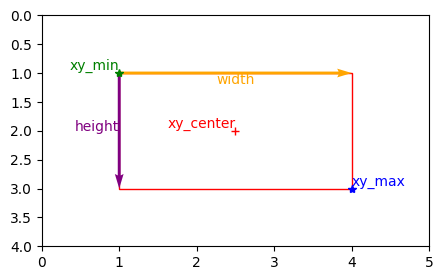

In [14]:
# This is just a code to visualize the coordinates conversion

# Visualisation
x_center = 2.5
y_center = 2
width = 3
height = 2
x_min, x_max = xywh2minmax(x_center,width)
y_min, y_max = xywh2minmax(y_center,height)

# Create the figure and axes
fig, ax = plt.subplots(figsize = (5,3))

# Add a rectangle to the plot
rectangle = patches.Rectangle(
    (x_min, y_min),
    width,
    height,
    edgecolor = 'red',
    facecolor='none',  # No filling
)
ax.add_patch(rectangle)

# Add the crosses
ax.plot(x_center, y_center, 'r+')
ax.text(x_center, y_center, 'xy_center', color='red', verticalalignment='bottom', horizontalalignment='right')
ax.plot(x_max, y_max, 'b*')
ax.text(x_max, y_max, 'xy_max', color='blue', verticalalignment='bottom', horizontalalignment='left')
ax.plot(x_min, y_min, 'g*')
ax.text(x_min, y_min, 'xy_min', color='green', verticalalignment='bottom', horizontalalignment='right')

ax.quiver(x_min, y_min, (x_max-x_min), 0, angles='xy', scale_units='xy', scale=1, color='orange')
ax.text(x_center, y_min, 'width', fontsize=10, ha='center', va='top', color = 'orange')
ax.quiver(x_min, y_min, 0, (y_max-y_min), angles='xy', scale_units='xy', scale=1, color='purple')
ax.text(x_min, y_center, 'height', fontsize=10, ha='right', color = 'purple')

ax.set_xlim(0, 5)
ax.set_ylim(0, 4)
ax.invert_yaxis()

# Display the plot
plt.show()

### 3.b.ii. Intersection over Union score
$A$ stands for area
$$
    A_{Union} = A_{box 1} + A_{box 2} - A_{intersection}
$$
<br>
$$
    IoU = \frac{A_{intersection}}{A_{Union}}
$$

In [15]:
def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    """
    Computes the Intersection over Union score between two boxes (predicted and ground truth)

    Parameters:
        - pred_mins: tensor [x, y] coordinates of the minimum point of the prediction
        - pred_maxes: tensor [x, y] coordinates of the maximum point of the prediction
        - true_mins: tensor [x, y] coordinates of the minimum point of the ground truth
        - true_mins: tensor [x, y] coordinates of the maximum point of the ground truth

    Return: the overlap score between prediction and ground truth
    """
    ## INTERSECTION
    # Keep the max of the min coordinates
    intersect_mins = K.maximum(pred_mins, true_mins)
    # Keep the min of the max coordinates
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    # Intersection area's width and heigh
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    # Area = width*height
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    ## UNION
    pred_wh = pred_maxes - pred_mins # prediction width and height
    true_wh = true_maxes - true_mins # true height width and height
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # prediction areas
    true_areas = true_wh[..., 0] * true_wh[..., 1] # true areas
    union_areas = pred_areas + true_areas - intersect_areas
    
    iou_scores = intersect_areas / union_areas

    return iou_scores

### 3.b.iii. Conversion output format to ground truth format

In [16]:
def yolo_head(feats):
    """
    Convert bounding box features into two separate tensors: xy coordinates and dimensions (weight and height).
    - xy coordinates are converted from grid cell scale to image scale
    - dimensions were and remain at image scale
    Finally, scales the coordinates and dimensions to the original image size (x448).
    
    Parameter:
        - feats: bounding box tensor only in the shape of (batch_size, 7, 7, n_box, [x, y, w, h])
        
    Return:
        - box_xy: tensor of shape (batch_size, 7, 7, n_box, [x, y])
        - box_wh: tensor of shape (batch_size, 7, 7, n_box, [w, h])
    """
    conv_dims = K.shape(feats)[1:3]  # shape=(2) -> [7. 7.]

    conv_height_index = K.arange(0, stop=conv_dims[0]) # -> [0, 1, 2, 3, 4, 5, 6]
    conv_width_index = K.arange(0, stop=conv_dims[1]) # idem
    # Repeat the height and width indices for each width value -> create a complete grid of indices
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]]) # shape=(49,) -> [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, ..., 4, 5, 6]
    conv_width_index = K.tile( K.expand_dims(conv_width_index, 0), [conv_dims[0], 1]) # shape=(7, 7)
            #  [[0 1 2 3 4 5 6]
            #        ...
            #  [0 1 2 3 4 5 6]]
    conv_width_index = K.flatten(K.transpose(conv_width_index)) # shape=(49,) -> [0, 0, 0, 0, 0, 0, 1, 1, 1, ..., 6, 6, 6]
    
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats)) # shape=(batch_size, 7, 7, 1, 2)
            # [[[[[0. 0.]]
            #    [[1. 0.]]
            #    [[2. 0.]]
            #    [[3. 0.]]
            #    [[4. 0.]]
            #    [[5. 0.]]
            #    [[6. 0.]]]

            #   [[[0. 1.]]
            #    [[1. 1.]]
            #    [[2. 1.]]
            #    [[3. 1.]]

            #      ...
            #    [[4. 6.]]
            #    [[5. 6.]]
            #    [[6. 6.]]]]]
    
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats)) # shape=(batch_size, 1, 1, 1, 2) -> [[[[[7. 7.]]]]]
    
    # Multiplication by 448
    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448 # -> shape=(batch_size, 7, 7, 7, 2)
    box_wh = feats[..., 2:4] * 448 # -> shape=(batch_size, 7, 7, 2)

    return box_xy, box_wh

### Loss function:
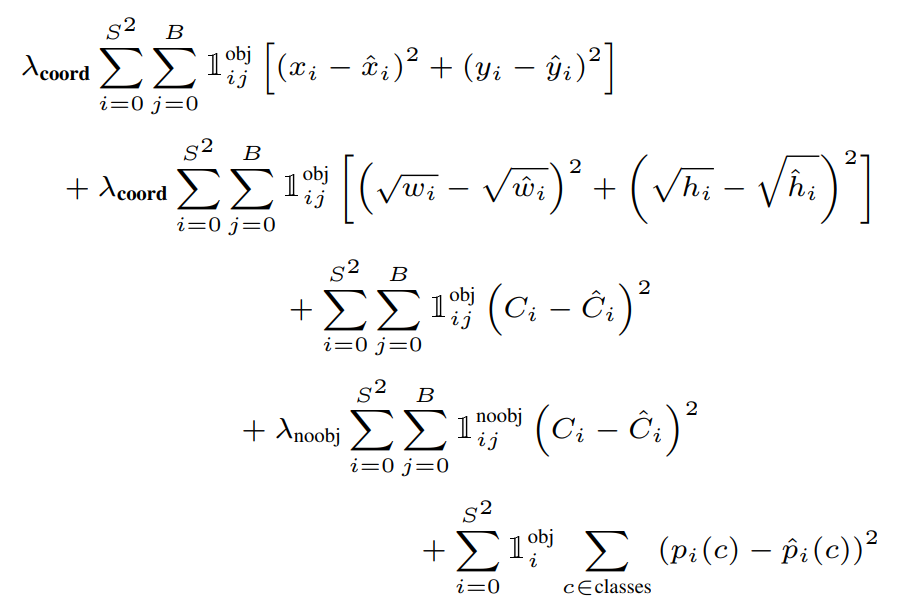

### **What is happening here?**

#### Bounding Box Coordinates Loss ($\lambda_{coord}$ term)
- **Input:** <br>
 - $\lambda_{\text{coord}}:$ Hyperparameter balancing the importance of bounding box coordinates loss.
 - $S^2 $: Number of grid cells in the output.
 - $B$: Number of bounding boxes predicted per grid cell.
 - $\sum_{i=0}^{S^2} \sum_{j=0}^{B} \text{obj}_{ij} $: Sum over grid cells and bounding boxes where an object is present.
  - $(x_i, y_i)$: True center coordinates of the bounding box.
  - $\text{obj}_{ij}$: Binary indicator ($1$ if object is present in cell $i$ and bounding box $j$, $0$ otherwise).
  - $\hat{x}_i, \hat{y}_i$: Predicted center coordinates of the bounding box.

- **Calculation:**
  $$ \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \text{obj}_{ij} \left( (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right) $$
- **Purpose:** Penalizes the model for inaccuracies in predicting the center coordinates of bounding boxes when an object is present.

#### Width and Height Loss ($\lambda_{coord}$ term)
- **Input:**
  - $h$: Height of the input image.
  - $\sqrt{w_i}, \sqrt{\hat{w}_i}$: True and predicted square root of the width of the bounding box.
  - $\sqrt{h_i}, \sqrt{\hat{h}_i}$: True and predicted square root of the height of the bounding box.
- **Calculation:**
$$ \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \text{obj}_{ij} \left( \left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)^2 + \left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)^2 \right)
$$
- **Purpose:** Penalizes the model for inaccuracies in predicting the width and height of bounding boxes when an object is present.

#### Object Confidence Loss
- **Input:**
  - $\text{obj}_{ij}$: Binary indicator ($1$ if object is present in cell $i$ and bounding box $j$, $0$ otherwise).
  - $C_i, \hat{C}_i$: True and predicted confidence scores for the presence of an object in cell $i$.

- **Calculation:**
$$\sum_{i=0}^{S^2} \sum_{j=0}^{B} \text{obj}_{ij} \left( (C_i - \hat{C}_i)^2 \right) $$

- **Purpose:** Penalizes the model for inaccuracies in predicting the confidence scores for the presence of an object in each grid cell.

#### No-Object Confidence Loss
- **Input:**
  - $\text{noobj}_{ij}$: Binary indicator ($1$ if no object is present in cell $i$ and bounding box $j$, $0$ otherwise).
  - $C_i, \hat{C}_i$: True and predicted confidence scores for the presence of an object in cell \(i\).
  
- **Calculation:**
$$ \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \text{noobj}_{ij} \left( (C_i - \hat{C}_i)^2 \right) $$

- **Purpose:** Penalizes the model for predicting the presence of an object in grid cells where no object is present.

#### Class Probability Loss
- **Input:**
  - $\text{obj}_i$: Binary indicator ($1$ if object is present in cell $i$, $0$ otherwise).
  - $p_i(c), \hat{p}_i(c)$: True and predicted class probabilities for class $c$ in cell $i$.

- **Calculation:**
$$ \sum_{i=0}^{S^2} \text{obj}_i \sum_{c \in \text{classes}} (p_i(c) - \hat{p}_i(c))^2 $$

- **Purpose:** Penalizes the model for inaccuracies in predicting class probabilities when an object is present in a grid cell.

In [17]:
def yolo_loss(y_true, y_pred):
    """
    Extracts class labels, confidence score, and bounding box coordinates from both true labels and predictions.
    Computes the Intersection over Union scores and identifies the best IOU for each predicted box.
    Defines confidence loss (confidence_loss), class prediction loss (class_loss), and bounding box loss (box_loss).
    Combines the losses with specified weights (0.5 for no object confidence, 5 for coordinates/dimensions, square root for dimensions).
    Compute the total loss as the sum of individual losses.
    
    Parameters:
    - y_true: tensor of ground truth
    - y_pred: tensor of predictions by the model
    
    Output:
    - loss: scalar representing the loss of the model
    """
    #  Extracts the TRUE class labels from the ground truth tensor
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    # 1 confidence: the 25th channel indicates whether object is present in grid cell
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1 -> Expands dimensions to make it compatible for further operations
    # 1 true bounding box
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    
    
    # Extracts the PREDICTED class probabilities from the model's output tensor
    predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
    # 2 confidences
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    # 2 bounding boxes
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

    # Reshapes the bounding box coordinates to have an additional dimension, preparing it for further calculations.
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    # Scale coordinates to image scale and multiply by 448
    label_xy, label_wh = yolo_head(_label_box)  # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    # Expands the dimensions
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    # Converts box coordinates to minimum and maximum format.
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # (? * 7 * 7 * 1 * 1 * 2), (? * 7 * 7 * 1 * 1 * 2)
    
    # Scale coordinates to image scale and multiply by 448
    predict_xy, predict_wh = yolo_head(_predict_box)  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)
    # Expands the dimensions
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
    # Converts box coordinates to minimum and maximum format.
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # (? * 7 * 7 * 2 * 1 * 2), (? * 7 * 7 * 2 * 1 * 2)
    
    # IOU SCORE between predict and truth
    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
    # Reshape iou_scores
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    # Selects the best iou score among the two predicted boxes
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

    # Assign 1 to the best bounding box, 0 to the other one
    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

    # LOSS CALCULATION
    ## Confidence loss: no object
    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    # True Positive  0.5 * (1 -    1     *       1      ) *         (0 -     0.9  )² = 0 -> because there is actually an object
    # True Negative  0.5 * (1 -   0/1    *       0      ) *         (0 -     0.1  )² = 0.005 (low cost)
    # False Postive  0.5 * (1 -    1     *       0      ) *         (0 -     0.9  )² = 0.405 (medium cost)
    # False Negative 0.5 * (1 -    1     *       1      ) *         (0 -     0.1  )² = 0 -> because there is actually an object    
    
    ## Confidence loss: object
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    # True Pos       1     *      1        *         (1 -   0.9  )² = 0.01 (low cost)
    # True Neg      0/1    *      0        *         (1 -   0.1  )² = 0 -> because there is actually no object
    # False Pos      1     *      0        *         (1 -   0.9  )² = 0 -> because there is actually no object
    # False Neg      1     *      1        *         (1 -   0.1  )² = 0.81 (high cost)

    # Sums up the confidence loss.
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss) # -> scalar

    ## Classes loss
    # class_loss: Loss for predicted class probabilities
    class_loss = response_mask * K.square(label_class - predict_class)
    # True Pos        obj=1    *         (   dog=1    -   0.9)² = 0.01 (low cost) -> There is a dog, and I'm sure it's a dog
    
    # True Neg        obj=0    *         (   cat=0    -   0.1)² = 0 -> There is no object, I can predict anything
    # True Neg        obj=1    *         (   boat=0   -   0.1)² = 0.01 (low cost) -> There is a dog, and I know it's not a boat
    
    # False Pos       obj=0    *         (   cat=0    -   0.9)² = 0 -> There is no object, I can predict anything
    # False Pos       obj=1    *         (   boat=0   -   0.9)² = 0.81 (high cost) -> There is a dog, but I'm sure it's a boat

    # False Neg       obj=1    *         (   dog=1    -   0.1)² = 0.81 (high cost) -> There is a dog, but I'm sure it's not a dog
    # Sums up the class loss
    class_loss = K.sum(class_loss) # -> scalar

    # Reshaping operations
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])  # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)

    label_xy, label_wh = yolo_head(_label_box)        # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    predict_xy, predict_wh = yolo_head(_predict_box)  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)

    box_mask = K.expand_dims(box_mask)           # ? * 7 * 7 * 2 * 1
    response_mask = K.expand_dims(response_mask) # ? * 7 * 7 * 1 * 1
    
    ## Bounding boxes loss
    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    # True Pos  5 *   1     *      1     *     ( 0.5/sqrt(0.5)  -   0.6/sqrt(0.6))² = 0.05 / 0.02 (low cost)
    # True Neg  5 *  0/1    *      0     *     (  0/sqrt(0)     -   0.1/sqrt(0.1))² = 0 -> I can predict anything
    # False Pos 5 *   1     *      0     *     (  0/sqrt(0)     -   0.5/sqrt(0.5))² = 0 -> I can predict anything    
    # False Neg 5 *   1     *      1     *     ( 0.5/sqrt(0.5)  -     0/sqrt(0)  )² = 1.25 / 2.5 (really high cost) 
    box_loss = K.sum(box_loss) # -> scalar

    # Combines the three components to get the final loss
    loss = confidence_loss + class_loss + box_loss
    
    return loss

In [18]:
# This is just a test to understand the box_mask behavior
shape_true = (1, 1, 1, 1, 1, 2)
shape_predict = (1, 1, 1, 2, 1, 2)

true_xy_min = np.zeros(shape_true)
true_xy_max = np.zeros(shape_true)
predict_xy_min = np.zeros(shape_predict)
predict_xy_max = np.zeros(shape_predict)

true_xy_min[0,0,0,0]=[0, 0]
true_xy_max[0,0,0,0]=[0, 0]

predict_xy_min[0,0,0] = [ [[5, 4]], [[1.5, 2]] ]
predict_xy_max[0,0,0] = [ [[5.05, 4.05]], [[1.5, 2]] ]

true_xy_min = tf.convert_to_tensor(true_xy_min)
true_xy_max = tf.convert_to_tensor(true_xy_max)
predict_xy_min = tf.convert_to_tensor(predict_xy_min)
predict_xy_max = tf.convert_to_tensor(predict_xy_max)

iou_scores = iou(predict_xy_min, predict_xy_max, true_xy_min, true_xy_max)  # ? * 7 * 7 * 2 * 1
best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
best_box = K.max(best_ious, axis=3, keepdims=True) 
box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2
box_mask = K.expand_dims(box_mask)

print(f'iou_scores: {iou_scores[0,0,0]}')
print(f'best_ious: {best_ious[0,0,0]}')
print(f'best_box: {best_box[0,0,0]}')
print(f'box_mask: {box_mask[0,0,0]}')

iou_scores: [[ 0.]
 [nan]]
best_ious: [ 0. nan]
best_box: [nan]
box_mask: [[0.]
 [0.]]


## 3.c. Model architecture

In [19]:
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

def yolo_cnn(input_shape):
    model = Sequential()
    # Conv. layer 1
    model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(2, 2), input_shape =input_shape, padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))
    
    # Conv. layer 2
    model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layer 3
    model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # lConv. layer 4
    model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 5
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 6
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 3
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layers 7-14
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv.layer 15
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 16
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # MaxPool layer 4
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

    # Conv. layers 17-20
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 21
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 22
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

    # Conv. layer 23
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
    # Conv. layer 24
    model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))

    model.add(Flatten()) # Transform the last output into a single vector
    
    model.add(Dense(4096))
    model.add(Dropout(0.5)) # Dropout rate to prevent overfitting
    model.add(Dense(1470, activation='sigmoid'))
    model.add(Yolo_Reshape(target_shape=(7,7,30)))
    
    
    model.compile(loss=yolo_loss, optimizer='adam')
    
    return model

## 3.d. Learning Rate

In [20]:
class CustomLearningRateScheduler(Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

      Argument:
      schedule: a function that takes an epoch index (integer, indexed from 0) and current learning rate
      as inputs and returns a new learning rate as output (float).
    """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        # checks whether the optimizer has a LR attribute
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call the provided schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the scheduled learning rate back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


# Define a schedule of learning rates at specific epochs
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]

def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    # If the epoch is before the first scheduled change or after the last, keep the current learning rate
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    # Iterate through the schedule and return the learning rate if the epoch matches a scheduled change
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
        
    # If the epoch is not in the schedule, keep the current learning rate
    return lr

## 3.e. Saving the best parameters

In [21]:
# Defining a function to save the weights of best model
checkpoint_filepath = 'best_weights.h5'
mcp_save = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

## 3.f. Define a progress bar

In [22]:
# Progress Bar
class ProgressBarLogger(Callback):
    def __init__(self):
        self.epochs = 0
        self.progbar = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epochs = self.params['epochs']
        self.progbar = Progbar(target=self.params['steps'])

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.progbar.update(batch, list(logs.items()))

# 4. Training the model
## 4.a. Splitting the dataset into train, validation and test sets
### 4.a.i. Filter data
Since there are more images than there are labels in the dataset, the images with no corresponding label must be removed.

In [23]:
# Paths to the directories
images_directory = '/kaggle/input/pascalvoc-yolo/images/'
labels_directory = '/kaggle/input/pascalvoc-yolo/labels/'

# Create lists of images' and labels' names
images_list = os.listdir(images_directory)
labels_list = os.listdir(labels_directory)
print('*** Before ***')
print(f'Image list length: {len(images_list)}')
print(f'Label list length: {len(labels_list)}\n')

# Extract file names without extension (.jpg or .txt)
images_noextension_set = set([os.path.splitext(image)[0] for image in images_list])
labels_noextension_set = set([os.path.splitext(label)[0] for label in labels_list])

# Find file names in common between the two sets
intersection_set = labels_noextension_set.intersection(images_noextension_set)

# Create two sorted lists of file names with the extensions
images_list = sorted([f"{filename}.jpg" for filename in intersection_set])
labels_list = sorted([f"{filename}.txt" for filename in intersection_set])
print('*** After ***')
print(f'Image list length: {len(images_list)}')
print(f'Label list length: {len(labels_list)}')

*** Before ***
Image list length: 43223
Label list length: 21503

*** After ***
Image list length: 21503
Label list length: 21503


### 4.a.ii. Split the lists of filenames into train, validation and test set

In [24]:
# Reducing the size of the dataset
images_list_small = images_list[:21440]
labels_list_small = labels_list[:21440]

# Split Data into Training and Testing size -> 20%
X_train_temp, X_test_filenames, Y_train_temp, Y_test_filenames = train_test_split(images_list_small, labels_list_small, test_size=0.2, random_state=456)

# Split training data into training and evaluation set -> 20% of the entire dataset or 1/4 of the train set
X_train_filenames, X_val_filenames, Y_train_filenames, Y_val_filenames = train_test_split(X_train_temp, Y_train_temp, test_size=(1/4), random_state=456)

print(f'Train shape: {len(X_train_filenames)}')
print(f'Validation shape: {len(X_val_filenames)}')
print(f'Test shape: {len(X_test_filenames)}')

Train shape: 12864
Validation shape: 4288
Test shape: 4288


### 4.a.iii. Create a generator for train and validation set 

In [25]:
batch_size = 64

# Initialize three generators (train, validation and test)
my_training_batch_generator = My_Custom_Generator(X_train_filenames, Y_train_filenames, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, Y_val_filenames, batch_size)

# Verification
X_train_gen, Y_train_gen = my_training_batch_generator.__getitem__(0)
print(f'Training set shape: {X_train_gen.shape}')
print(f'Training target shape: {Y_train_gen.shape}')

Training set shape: (64, 448, 448, 3)
Training target shape: (64, 7, 7, 30)


## 4.b. Training with train and validation set

In [26]:
# Remove the number of images in the batch to only keep the real shape of the input
input_shape = (X_train_gen.shape[1], X_train_gen.shape[2], X_train_gen.shape[3])

model = yolo_cnn(input_shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 192)     110784    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 192)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       24704     
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [27]:
yolo_trained = model.fit(
            x=my_training_batch_generator,
            epochs = 135,
            workers= 4,
            validation_data = my_validation_batch_generator,
            callbacks=[
              CustomLearningRateScheduler(lr_schedule),
              ProgressBarLogger(),
              mcp_save,
            ],
            verbose = 2
)


Epoch 00000: Learning rate is 0.0100.
Epoch 1/135
200/201 [============================>.] - ETA: 0s - loss: 1013.7123
Epoch 1: val_loss improved from inf to 951.52264, saving model to best_weights.h5
201/201 - 205s - loss: 970.4716 - val_loss: 951.5226 - 205s/epoch - 1s/step

Epoch 00001: Learning rate is 0.0100.
Epoch 2/135
200/201 [============================>.] - ETA: 0s - loss: 948.3508
Epoch 2: val_loss improved from 951.52264 to 949.54089, saving model to best_weights.h5
201/201 - 160s - loss: 945.8386 - val_loss: 949.5409 - 160s/epoch - 794ms/step

Epoch 00002: Learning rate is 0.0100.
Epoch 3/135
200/201 [============================>.] - ETA: 0s - loss: 959.4524
Epoch 3: val_loss did not improve from 949.54089
201/201 - 158s - loss: 970.2545 - val_loss: 963.6708 - 158s/epoch - 784ms/step

Epoch 00003: Learning rate is 0.0100.
Epoch 4/135
200/201 [============================>.] - ETA: 0s - loss: 966.2921
Epoch 4: val_loss did not improve from 949.54089
201/201 - 157s - loss

# 5. Evaluating the model

## 5.a. Create a generator for the test set

In [28]:
# Sort the arrays for better handling of the outputs
X_test_filenames = np.sort(X_test_filenames)
Y_test_filenames = np.sort(Y_test_filenames)

# Create generator for test set
my_test_batch_generator = My_Custom_Generator(X_test_filenames, Y_test_filenames, batch_size)

## 5.b Generate predictions on the test set

In [29]:
yolo_predictions = model.predict(
        my_test_batch_generator,
        workers = 4,
        verbose = 2
)

67/67 - 41s - 41s/epoch - 608ms/step


# 6. mAP comparison between our model and the one from the original paper
## 6.a. Implement mAP workflow
### 6.a.i. Install the package

In [30]:
# Install Git
!apt-get install -y git

# Clone the Git repository
!git clone https://github.com/Cartucho/mAP




git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 78 not upgraded.
Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 908 (delta 135), reused 125 (delta 125), pack-reused 758
Receiving objects: 100% (908/908), 14.70 MiB | 41.25 MiB/s, done.
Resolving deltas: 100% (329/329), done.


### 6.a.ii. Clean the folders

In [31]:
def rename_folder(current_folder_path, new_folder_path):
    try:
        os.rename(current_folder_path, new_folder_path)
        print(f"Folder '{current_folder_path}' renamed to '{new_folder_path}' successfully.")
    except Exception as e:
        print(f"Failed to rename folder. Error: {e}")

def delete_files(folder_path):
    # Get a list of all files in the folder
    files_in_folder = os.listdir(folder_path)

    # Iterate through the files and delete them
    for file_name in files_in_folder:
        file_path = os.path.join(folder_path, file_name)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete '{file_path}'. Error: {e}")
            
def delete_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"File {file_path} has been deleted.")
    else:
        print(f"File {file_path} does not exist.")
        
def copy_files(source_folder_path, destination_folder_path, filenames_set):   
    for filename in filenames_set:
        source_file_path = source_folder_path + filename
        shutil.copy(source_file_path, destination_folder_path)

def count_files_in_folder(folder):
    if os.path.isdir(folder):
        # List all files in the folder
        files = os.listdir(folder)
        
        # Filter only files (not subdirectories)
        files = [f for f in files if os.path.isfile(os.path.join(folder, f))]
        
        # Display the number of files
        print(f"The number of files in the folder {folder} is: {len(files)}")
    else:
        print(f"{folder} is not a valid folder path.")

In [32]:
# Rename the folder
rename_folder('/kaggle/working/mAP/input/images-optional/', '/kaggle/working/mAP/input/images/')

# Files deletion
delete_files('/kaggle/working/mAP/input/ground-truth/')
delete_files('/kaggle/working/mAP/input/images/')
delete_files('/kaggle/working/mAP/input/detection-results/')
delete_file('/kaggle/working/mAP/scripts/extra/class_list.txt')

# Create new class_list file
file_path = '/kaggle/working/mAP/scripts/extra/class_list.txt'
class_list = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
with open(file_path, 'w') as file:
    for clss in class_list:
        file.write(clss + '\n')
        
# Copy raw files into the mAP folder
copy_files('/kaggle/input/pascalvoc-yolo/labels/', '/kaggle/working/mAP/input/ground-truth/', Y_test_filenames)
copy_files('/kaggle/input/pascalvoc-yolo/images/', '/kaggle/working/mAP/input/images/', X_test_filenames)

# Verification
count_files_in_folder('/kaggle/working/mAP/input/ground-truth/')
count_files_in_folder('/kaggle/working/mAP/input/images/')

Folder '/kaggle/working/mAP/input/images-optional/' renamed to '/kaggle/working/mAP/input/images/' successfully.
File /kaggle/working/mAP/scripts/extra/class_list.txt has been deleted.
The number of files in the folder /kaggle/working/mAP/input/ground-truth/ is: 4288
The number of files in the folder /kaggle/working/mAP/input/images/ is: 4288


### 6.a.ii. Convert ground-truth to mAP calculation format

Calculation to obtain the mAP format: <br>
* left = $x \times w_{image} - \frac{w_{box} \times w_{image}}{2} + 1$ <br>
* right = $x \times w_{image} + \frac{w_{box} \times w_{image}}{2} + 1$ <br>
* top = $y \times h_{image} - \frac{h_{box} \times h_{image}}{2} + 1$ <br>
* bottom = $y \times h_{image} + \frac{h_{box} \times h_{image}}{2} + 1$ <br>

In [33]:
!python mAP/scripts/extra/convert_gt_yolo.py

Conversion completed!


### 6.a.iii. Convert outputs to mAP calculation format

In [34]:
def xywh2minmax_mAP(xy, wh, wh_img):
    """
    Converts bounding box coordinates from center (x, y) and width-height (w, h) format
    to left, top, right, bottom format (scaled on the image real size)
    """
    wh_img = tf.cast(wh_img, dtype=xy.dtype)

    xy_min = xy * (wh_img/448) - wh * wh_img /(448*2) +1
    xy_max = xy * (wh_img/448) + wh * wh_img /(448*2) +1
    
    return xy_min, xy_max

def get_wh_tensor(batch_size=64):
    num_images = len(X_test_filenames)
    images_wh = np.zeros((num_images, 7, 7, 2), dtype=np.float32)

    for i in range(0, num_images, batch_size):
        batch_filenames = X_test_filenames[i:i+batch_size]
        batch_images = [Image.open(os.path.join('/kaggle/input/pascalvoc-yolo/images/', img_name)) for img_name in batch_filenames]

        for j, img in enumerate(batch_images):
            width, height = img.size
            images_wh[i+j, :, :, 0] = width
            images_wh[i+j, :, :, 1] = height
            
    return tf.convert_to_tensor(images_wh)


def extract_conf_bbox(tsf_predictions):
    """
    Return 1 tensor of shape (test_size, 7, 7, 5):
        - confidence
        - left
        - top
        - right
        - bottom
    """
    # Extract confidence and bounding box 1
    confidence_1 = K.expand_dims(tsf_predictions[..., 20])
    bbox_1 = tsf_predictions[..., 22:26]
    conf_bbox_1 = tf.concat([confidence_1, bbox_1], axis=-1) # ? * 7 * 7 * 5
    # Extract confidence and bounding box 2
    confidence_2 = K.expand_dims(tsf_predictions[..., 21])
    bbox_2 = tsf_predictions[..., 26:]
    conf_bbox_2 = tf.concat([confidence_2, bbox_2], axis=-1) # ? * 7 * 7 * 5
    # Keep the bbox with the highest confidence
    condition = conf_bbox_1[..., 0] > conf_bbox_2[..., 0]
    predict_conf_box = tf.where(condition[..., tf.newaxis], conf_bbox_1, conf_bbox_2)
    # Save confidence
    conf = K.expand_dims(predict_conf_box[...,0])

    predict_box = K.expand_dims(predict_conf_box[..., 1:], 3) # ? * 7 * 7 * 1 * 4

    # Scale coordinates to the image scale and multiply by 448
    predict_xy, predict_wh = yolo_head(predict_box) # (? * 7 * 7 * 1 * 2), (? * 7 * 7 * 1 * 2)
    predict_xy = K.expand_dims(predict_xy, 4)     # ? * 7 * 7 * 1 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)     # ? * 7 * 7 * 1 * 1 * 2
    wh_images = K.expand_dims(K.expand_dims(get_wh_tensor(), 3),3) # ? * 7 * 7 * 1 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax_mAP(predict_xy, predict_wh, wh_images)  # (? * 7 * 7 * 2 * 2), (? * 7 * 7 * 2 * 2)
    
    left = tf.squeeze(predict_xy_min[..., 0], axis=4)
    top = tf.squeeze(predict_xy_min[..., 1], axis=4)
    right = tf.squeeze(predict_xy_max[..., 0], axis=4)
    bottom = tf.squeeze(predict_xy_max[..., 1], axis=4)

    conf_bbox = tf.concat([conf, left, top, right, bottom], axis=-1)

    return conf_bbox


def output2mAP_format(tsf_predictions):
    """
    From the tensor of outputs 'tsf_predictions', return a numpy array in mAP format.
    """
    # Extracts the PREDICTED class probabilities from the model's output tensor
    class_idx = tf.argmax(tsf_predictions[..., :20], axis=-1)
    class_idx = tf.expand_dims(class_idx, axis=-1)
    
    conf_bbox = extract_conf_bbox(tsf_predictions)
    
    class_idx = tf.cast(class_idx, dtype=conf_bbox.dtype)
    predictions = tf.concat([class_idx, conf_bbox], axis=-1)
    
    # Remove all prediction where confidence <0.2
    mask_bad_predict = predictions[..., 1] < 0.2
    good_predict = tf.where(mask_bad_predict[..., tf.newaxis], 0, predictions)

    # Reshaping
    reshaped_predict = tf.reshape(good_predict, (-1, 49, 6))

    return reshaped_predict.numpy()

In [35]:
# This is just a test to check the previous code
number = '001' # 3 digits
image_name = '000' + number + '.jpg'
label_name = '000' + number + '.txt'
    
image_matrix, label_matrix = read(image_name, label_name)

temp_bbox = label_matrix[4,2,20:24].copy()
label_matrix[4,2,20] = label_matrix[4,2,24]
label_matrix[4,2,21] = 0
label_matrix[4,2,22:26] = temp_bbox

temp_bbox = label_matrix[3,3,20:24].copy()
label_matrix[3,3,20] = label_matrix[3,3,24]
label_matrix[3,3,21] = 0
label_matrix[3,3,22:26] = temp_bbox
tsf_predictions = tf.convert_to_tensor(label_matrix)
tsf_predictions = K.expand_dims(tsf_predictions, 0)
tsf_predictions = tf.tile(tsf_predictions, multiples=(len(X_test_filenames), 1, 1, 1))

test = output2mAP_format(tsf_predictions)
test[0,20:32]

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [ 14.,   1.,   9.,  13., 353., 499.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [ 11.,   1.,  49., 241., 196., 372.],
       [  0.,   0.,   0.,   0.,   0.,   0.]])

In [36]:
# From the outputs, create a numpy array in mAP format
detect_res = output2mAP_format(yolo_predictions)
detect_res.shape

(4288, 49, 6)

### 6.a.iiii Creates file text in mAP format

In [37]:
# Output directory for saving text files
output_dir = "/kaggle/working/mAP/input/detection-results/"
os.makedirs(output_dir, exist_ok=True)

# Iterate over the array and save each entry to a text file named based on Y_test_filenames
for i_img in range(detect_res.shape[0]):
    # Create a separate text file for each entry
    output_file = os.path.join(output_dir, Y_test_filenames[i_img])
    with open(output_file, 'w') as f:
        for i_obj in range(detect_res.shape[1]):
            # Extract relevant information
            class_index = int(detect_res[i_img, i_obj, 0])
            class_name = class_list[class_index]
            confidence = detect_res[i_img, i_obj, 1]
            left = int(detect_res[i_img, i_obj, 2])
            top = int(detect_res[i_img, i_obj, 3])
            right = int(detect_res[i_img, i_obj, 4])
            bottom = int(detect_res[i_img, i_obj, 5])

            # Save the entry to the text file
            f.write(f'{class_name} {confidence} {left} {top} {right} {bottom}\n')

print("Text files saved.")

Text files saved.


## 6.b. Calculate the mAP

In [38]:
!python mAP/main.py --no-animation --no-plot

0.11% = aeroplane AP 
0.03% = bicycle AP 
0.02% = bird AP 
0.00% = boat AP 
0.00% = bottle AP 
0.00% = bus AP 
0.01% = car AP 
0.41% = cat AP 
0.00% = chair AP 
0.00% = cow AP 
0.00% = diningtable AP 
0.00% = dog AP 
0.00% = horse AP 
0.00% = motorbike AP 
0.00% = person AP 
0.00% = pottedplant AP 
0.00% = sheep AP 
0.00% = sofa AP 
0.00% = train AP 
0.00% = tvmonitor AP 
mAP = 0.03%


## 6.c. Display the evolution of the losses through training

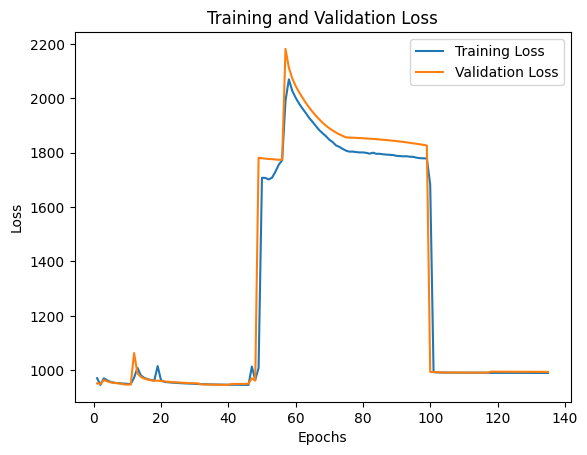

In [39]:
train_loss = yolo_trained.history['loss']
val_loss = yolo_trained.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [40]:
 score = model.evaluate(
     x = my_test_batch_generator,
     batch_size = 64,
     verbose = 2
 )

67/67 - 53s - loss: 996.3380 - 53s/epoch - 787ms/step


In [41]:
# # To reuse the best parameters
# best_model = keras.Sequential.from_config(model.get_config)

# # Charge best weights
# loaded_model.load_weights('model_weights.h5')

This code was heavily inspired by Vivek Maskara's tutorial, which can be found at: https://www.maskaravivek.com/post/yolov1/ <br>
The mAP package comes from João Cartucho, whose code can be found here: https://github.com/Cartucho/mAP.